## Import

In [16]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

torch.__version__

'1.13.1+cpu'

In [2]:
pytorch_workflow = {10:'data (prepare and load))', 
                    #torchvision.transforms
                    #torch.utils.data.Dataset
                    #torch.utils.data.DataLoader
                    20:'model (define and initialize)', 
                    21:'loss (define and initialize)', 
                    #torch.nn
                    #torch.nn.Module
                    #torchvision.models
                    22:'optimizer (define and initialize)', 
                    #torch.optim
                    30:'Fit the model', 
                    40:'evaluation (compute loss and accuracy)', 
                    #torchmetrics
                    50:'Improve the model (hyperparameter tuning)', 
                    #torch.utils.tensorboard
                    60:'Save and load the model', 
                    70:'Save and reload the model', 
                    80:'Inference (predict on new data)'}

## 10. Data (prepare and load)

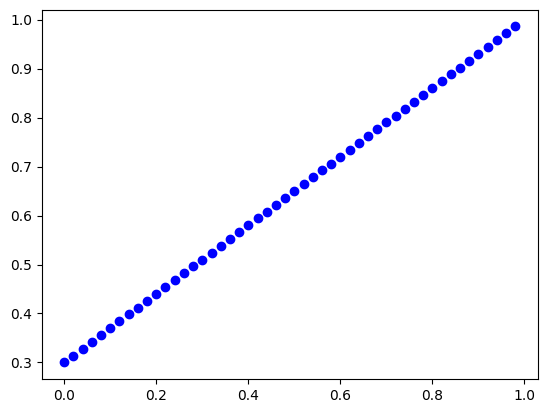

In [102]:
import torch
import matplotlib.pyplot as plt

#Known parameters
weight = 0.7 #slope
bias = 0.3 #intercept

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step)
y = weight * X + bias
plt.plot(X, y, 'bo')

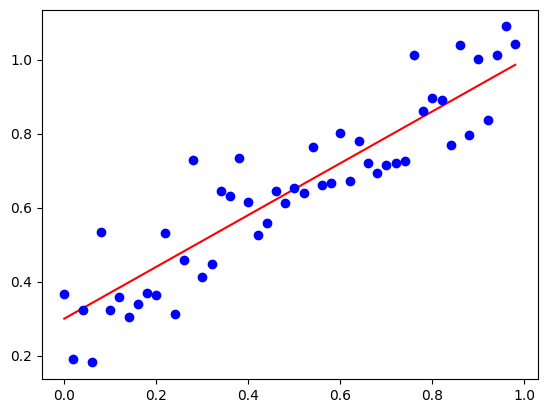

In [103]:
## Add noise
noise = torch.randn(y.shape) * 0.1
y1 = y + noise
plt.plot(X, y, 'r-')
plt.plot(X, y1, 'bo')

In [104]:
# Create train and test data
train_split = int(0.8*len(X))
X_train,y_train = X[:train_split], y1[:train_split]
X_test,y_test = X[train_split:], y1[train_split:]
len(X_train), len(X_test)

(40, 10)

In [105]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})

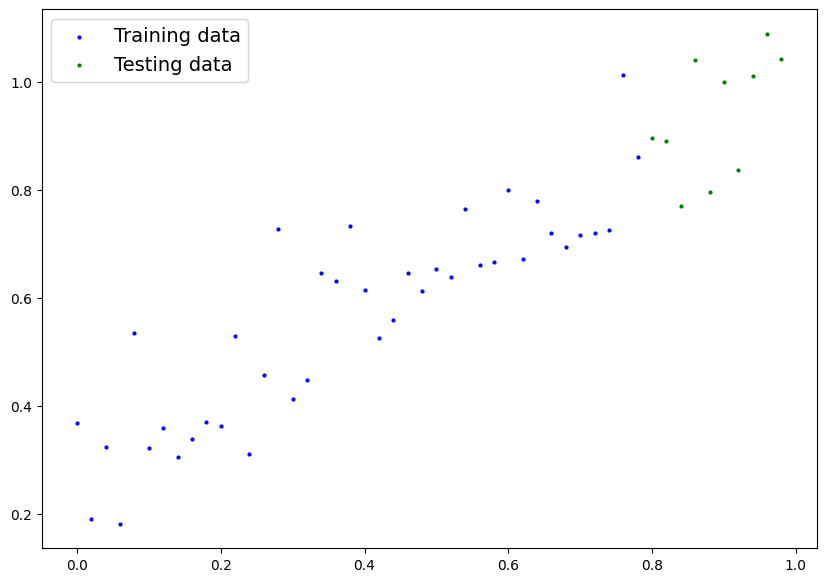

In [106]:
plot_predictions()

## Define the model

In [156]:
# Create a linear regression model class
from torch import nn
class LinearRegressionModel(nn.Module): # Almost everything in pytorch inherits from nn.Module
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, #Starting random weight
                                               dtype = torch.float,
                                               requires_grad = True))
        self.bias = nn.Parameter(torch.randn(1,
                                             dtype = torch.float,
                                             requires_grad = True))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

### Pytorch model building essentials

In [157]:
# Create a random seed to ensure consistency
torch.manual_seed(42)

#Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()
print(list(model_0.parameters()))
print(model_0.state_dict())

[Parameter containing:
tensor([0.3367], requires_grad=True), Parameter containing:
tensor([0.1288], requires_grad=True)]
OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])


In [158]:
#Making predictions with our model using torch.inference_mode() (No backpropagation)

with torch.inference_mode(): #Inference mode turns off autograd
    y_preds = model_0(X_test) #If inference mode is not used, need to .detach().numpy() the tensor
y_preds

tensor([0.3982, 0.4049, 0.4116, 0.4184, 0.4251, 0.4318, 0.4386, 0.4453, 0.4520,
        0.4588])

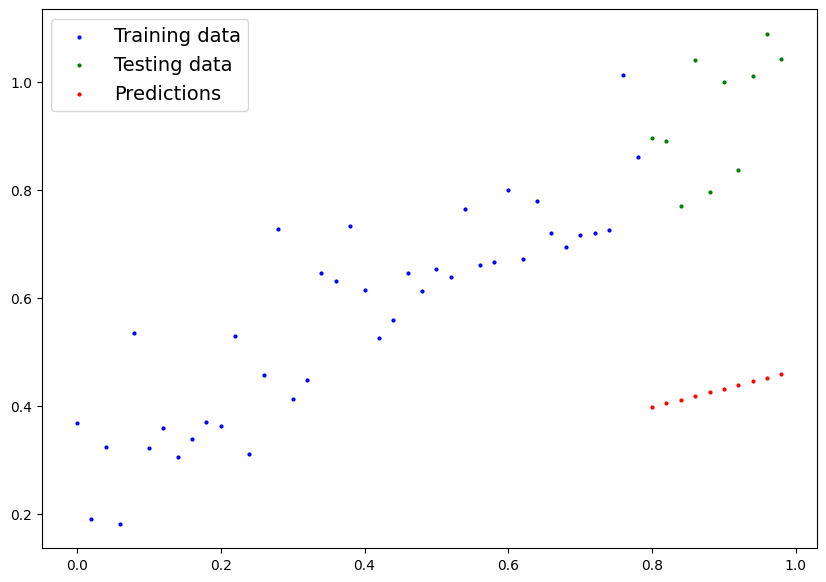

In [159]:
#y_preds = model_0(X_test)
#plot_predictions(predictions=y_preds.detach().numpy())
plot_predictions(predictions=y_preds)

In [160]:
#Loss function - A function that measures the incorrectness of the model's predictions to the ideal outputs. Lower loss = better model
#Optimizers - A function that updates the model's parameters to try and improve the model's predictions.
#L1loss = mean absolute error (MAE) mean(abs(y_pred - y_true))
import numpy as np
(y_preds - y_test).abs().mean()

tensor(0.5090)

In [161]:
#Seting up the loss function
loss_fn = nn.L1Loss()

#Settting up the optimizer
optimizer = torch.optim.SGD(model_0.parameters(), 
                            lr=0.01)

### Building a training loop

In [162]:
#Step 1 - Get the model's predictions (Forward Pass)
#Step 2 - Calculate the loss (loss_fn)
#Step 3 - Update the model's parameters to try and reduce the loss based on the gradients (optimizer.step) (Backward Propagation)
#Step 4 - Repeat until the gradients to zero (local minimum is reached when the gradient is zero)
#Step 5 - Stop the model training when the loss stops decreasing
#Step 6 - Make predictions with the updated model (Inference)

In [163]:
epochs = 1000 #Each epoch is a full pass through the training data
loss_path = [] #Store the loss for every 50 epochs

for epoch in range(epochs):
    
    model_0.train() #Put the model in training mode with calculating gradients
    
    #Step 1 - Get the model's predictions (Forward Pass)
    y_pred = model_0(X_train)
    
    #Step 2 - Calculate the loss (loss_fn)
    loss = loss_fn(y_pred, y_train) #Calculate the MAE between the predictions and the true labels
    
    if epoch == 0:
        print(f'Epoch: {epoch}, Loss: {loss}')
        print(f'State Dictionary: {model_0.state_dict()}')
    
    #Step 3 - Update the model's parameters to try and reduce the loss based on the gradients (optimizer.step) (Backward Propagation)
    optimizer.zero_grad() #Clear the gradients from the previous step
    
    #Perform a backward pass (backpropagation)
    loss.backward()
    
    #Update the parameters
    optimizer.step() #By default, the gradients are accumulated in the .grad attribute of the parameters; thus, it must be zeroed out before the next backward pass

    
    #Step 4 - Repeat until the gradients to zero (local minimum is reached when the gradient is zero)
    loss_path.append(loss.detach())
    if epoch % 10 == 0:
        loss_path.append(loss.detach())
        print(f'State Dictionary: {model_0.state_dict()}')
        
        ###Testing the model    

        model_0.eval() #Put the model in evaluation mode without calculating gradients
        with torch.inference_mode():
            #Test predictions
            y_preds = model_0(X_test)
            #Calculate the loss
            test_loss = loss_fn(y_preds, y_test)

    
            print(f'Epoch: {epoch}, Train loss: {loss}, Test Loss: {test_loss}')
            print('\n')

    
    

#Step 5 - Stop the model training when the loss stops decreasing or epochs are reached
#Step 6 - Make predictions with the updated model (Inference)

Epoch: 0, Loss: 0.30502715706825256
State Dictionary: OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])
State Dictionary: OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 0, Train loss: 0.30502715706825256, Test Loss: 0.4954986572265625


State Dictionary: OrderedDict([('weights', tensor([0.3792])), ('bias', tensor([0.2323]))])
Epoch: 10, Train loss: 0.20031456649303436, Test Loss: 0.3676268458366394


State Dictionary: OrderedDict([('weights', tensor([0.4150])), ('bias', tensor([0.3073]))])
Epoch: 20, Train loss: 0.12757863104343414, Test Loss: 0.26080936193466187


State Dictionary: OrderedDict([('weights', tensor([0.4446])), ('bias', tensor([0.3478]))])
Epoch: 30, Train loss: 0.10034607350826263, Test Loss: 0.19392971694469452


State Dictionary: OrderedDict([('weights', tensor([0.4695])), ('bias', tensor([0.3738]))])
Epoch: 40, Train loss: 0.08680125325918198, Test Loss: 0.14578643441200256


State Dictionary: OrderedDict([('wei

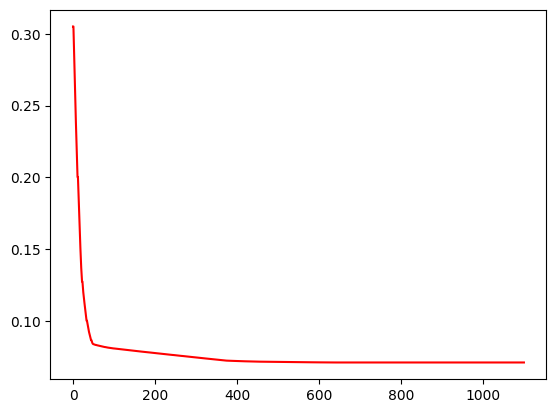

In [164]:
x = np.arange(0, len(loss_path))
plt.plot(list(x), loss_path, 'r-')

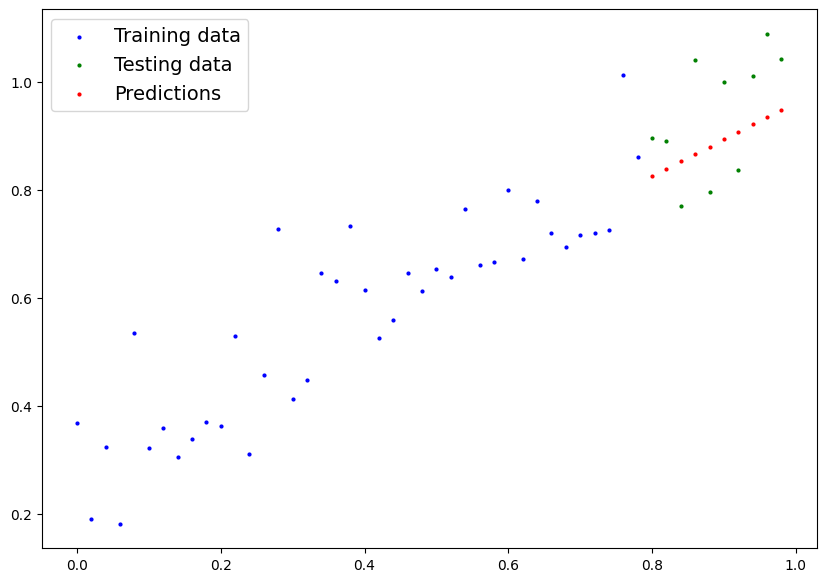

In [165]:
y_pred = model_0(X_test)
plot_predictions(predictions=y_pred.detach().numpy())

In [117]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6853])), ('bias', tensor([0.2773]))])

## Save and load pytorch models

1. torch.save() - Saves python object in .pkl
2. torch.load() - Loads python object from .pkl
3. torch.nn.Module.load_state_dict() - Loads model parameters

In [168]:
import os

model_path = 'models_user'

#make file directiry if it doesn't exist
os.makedirs(model_path, exist_ok=True)
#model_path.mkdir(parents=True, exist_ok=True)

model_name = 'model_0.pkl'
file_path = os.path.join(model_path, model_name)
torch.save(model_0.state_dict(), file_path)


In [169]:
#Load the model
loaded_model_0 = LinearRegressionModel()

loaded_model_0.load_state_dict(torch.load(file_path))

<All keys matched successfully>

In [171]:
print(model_0.state_dict())
print(loaded_model_0.state_dict())

OrderedDict([('weights', tensor([0.6853])), ('bias', tensor([0.2773]))])
OrderedDict([('weights', tensor([0.6853])), ('bias', tensor([0.2773]))])
